<a href="https://colab.research.google.com/github/MHzNug/Project-Analisis-Sentiment/blob/main/Project_Analisis_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Import Library**

In [1]:
# Manipulasi Data
import pandas as pd
import numpy as np
import re
import string

# Visualisasi Data
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Mengakses Data  Ulasan dan Informasi Aplikasi
from google_play_scraper import Sort, reviews

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import requests
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# **2. Memuat Dataset**

In [2]:
# Mengambil Data Review Aplikasi
result, _ = reviews(
    'com.kai.kaiticketing',     # Ganti dengan ID aplikasi target
    lang='id',              # Bahasa Indonesia
    country='id',           # Negara Indonesia
    sort=Sort.NEWEST,       # Bisa NEWEST, RATING, atau HELPFUL
    count=15000             # Jumlah review yang ingin diambil
)

# Melihat hasil
for r in result[:5]:
    print(f"[{r['score']}★] {r['content']}")

[5★] mudah digunakan
[2★] bila kondisi mendesak,top up kai pay tidak bisa langsung masuk tp harus menunggu 15 menit dan itupun harus berbayar Rp.2500
[5★] good
[5★] bagus
[5★] good


In [3]:
# Melihat DataFrame
df = pd.DataFrame(result)
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,c2ebe6d5-0366-49a9-8302-fce8567502f4,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,mudah digunakan,5,0,6.11.2,2025-04-13 02:22:02,None,NaT,6.11.2
1,327d3424-1356-4c8c-9578-e780e4a73598,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"bila kondisi mendesak,top up kai pay tidak bis...",2,0,6.11.2,2025-04-13 02:15:05,None,NaT,6.11.2
2,d0be4b79-c125-4834-a342-2af6e2c38709,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,good,5,0,6.11.2,2025-04-13 02:09:58,None,NaT,6.11.2
3,1b9e0b38-d915-407d-9be3-733c6051a2f2,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,bagus,5,0,6.11.2,2025-04-13 02:07:06,None,NaT,6.11.2
4,3611edbf-c27e-4dd6-9214-bc227ae536c3,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,good,5,0,6.11.2,2025-04-13 01:54:16,None,NaT,6.11.2


In [4]:
# Jumlah data
len(df)

15000

# **3. Exploratory Data Analysis (EDA)**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              15000 non-null  object        
 1   userName              15000 non-null  object        
 2   userImage             15000 non-null  object        
 3   content               15000 non-null  object        
 4   score                 15000 non-null  int64         
 5   thumbsUpCount         15000 non-null  int64         
 6   reviewCreatedVersion  11809 non-null  object        
 7   at                    15000 non-null  datetime64[ns]
 8   replyContent          716 non-null    object        
 9   repliedAt             716 non-null    datetime64[ns]
 10  appVersion            11809 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 1.3+ MB


In [6]:
# Mengambil Data Score dan Review
df = df[['score', 'content']]
df.head()

,score,content
0,5,mudah digunakan
1,2,"bila kondisi mendesak,top up kai pay tidak bis..."
2,5,good
3,5,bagus
4,5,good


In [7]:
# Memeriksa Nilai yang Hilang
df.isnull().sum()

,0
score,0
content,0


In [8]:
# Memeriksa Data Duplikat
df.duplicated().sum()

np.int64(1290)

In [9]:
# Menghapus Data Duplikat
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

In [10]:
# Data Setelah Menghapus Duplikat
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13710 entries, 0 to 14999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   score    13710 non-null  int64 
 1   content  13710 non-null  object
dtypes: int64(1), object(1)
memory usage: 321.3+ KB


In [11]:
# jumlah Data Setiap Scorenya
df['score'].value_counts()

,count
score,
1,8634
5,2539
2,1208
3,785
4,544


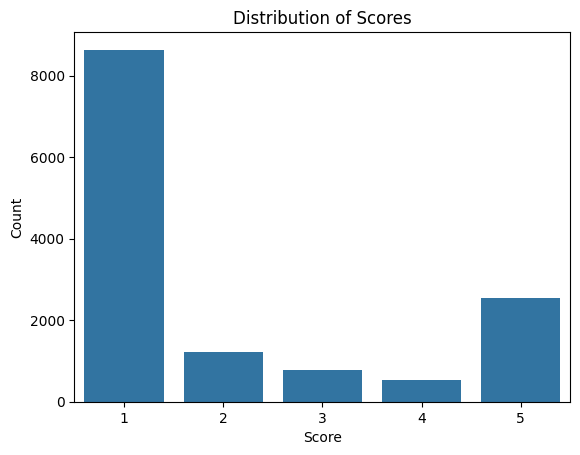

In [12]:
# Plot Score
sns.countplot(x='score', data=df)
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

<ipython-input-13-d3864e4bbc60>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), ax=axes[1], palette='viridis')


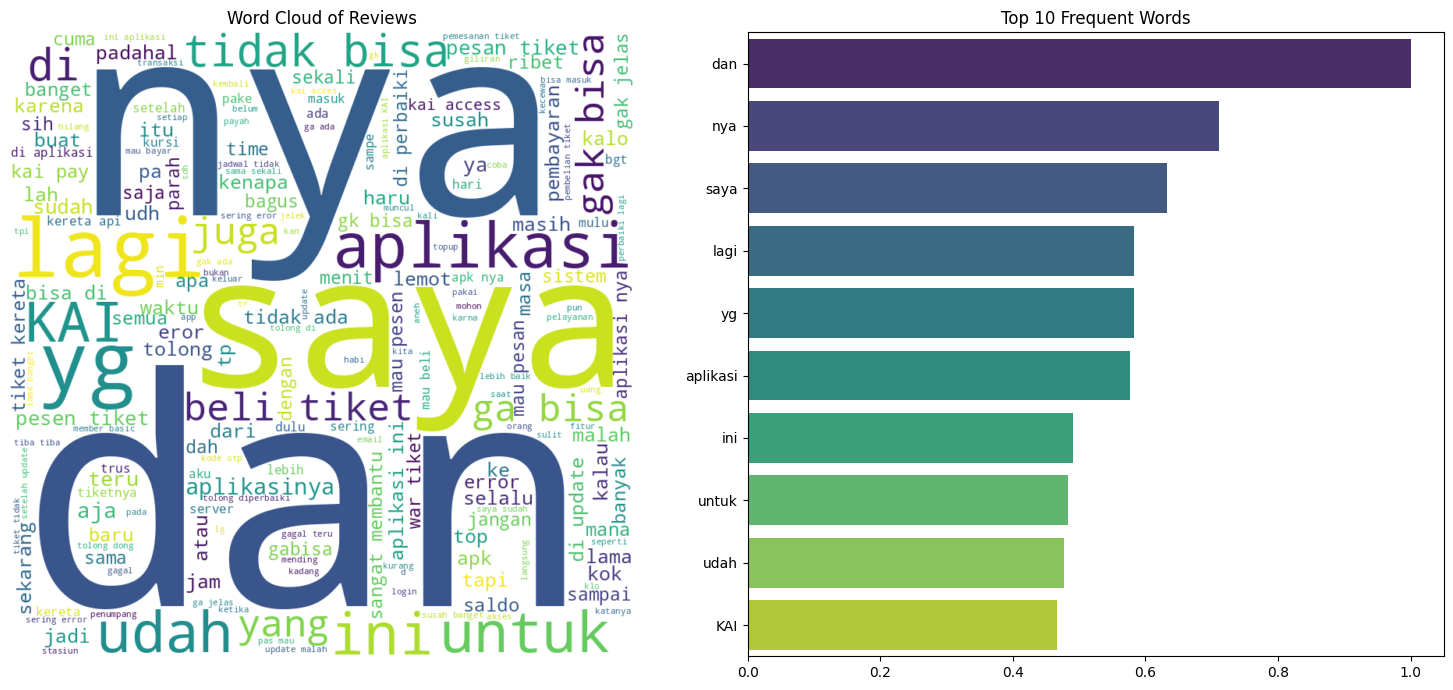

In [13]:
# Membuat Word Cloud
text = ' '.join(df['content'].tolist())
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(text)

# Mendapatkan frekuensi kata dari wordcloud
frequencies = wordcloud.words_

# Menyiapkan data untuk barplot (10 kata paling sering)
words, counts = zip(*list(frequencies.items())[:10])

# Membuat subplots (2 kolom: WordCloud dan Barplot)
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Menampilkan WordCloud
axes[0].imshow(wordcloud, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Word Cloud of Reviews')

# Menampilkan horizontal barplot
sns.barplot(x=list(counts), y=list(words), ax=axes[1], palette='viridis')
axes[1].set_title('Top 10 Frequent Words')

# Menampilkan plot
plt.tight_layout()
plt.show()

# **4. Data Preprocessing**

In [ ]:
def label_sentiment(score):
    if score in [5,]:
        return 'positive'
    elif score in [1,]:
        return 'negative'
    else:
        return 'neutral'

In [15]:
# Membuat Fungsi untuk Memebersihkan Data Review
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka

    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text

def casefoldingText(text): # Mengubah semua karakter dalam teks menjadi huruf kecil
    text = text.lower()
    return text

def tokenizingText(text): # Memecah atau membagi string, teks menjadi daftar token
    text = word_tokenize(text)
    return text

def filteringText(text): # Menghapus stopwords dalam teks
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text): # Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence

In [ ]:
stopwords.words('indonesian')

In [16]:
url = "https://raw.githubusercontent.com/King-srt/Indonesia-Slang-Dictionary/refs/heads/main/dictionary_indonesia.txt"
response = requests.get(url)

# Inisialisasi dictionary kosong untuk menyimpan slang dan kata formal
slangwords = {}

# Ganti tanda kutip tunggal dengan tanda kutip ganda
cleaned_text = response.text.replace("’", "'")

for line in response.text.strip().split("\n"):
    if "," in line:
        slang, formal = line.strip().split(",", 1)
        slangwords[slang.strip()] = formal.strip()

# Menambahkan entri manual dalam bentuk dictionary
manual_entries = {
    "sy": "saya", "tul": "betul", "pa": "apa", "aqu": "aku", "cepa": "cepat", "coffie": "kopi",
    "sukaxbelanja": "suka sekali belanja", "luv": "suka", "sdiakan": "sediakan", "baguusss" : "bagus",
    "bagusteruskan": "bagus teruskan", "mantatatap": "mantap", "mantafz": "mantap", "mangtaps": "mantap",
    "mantabsss": "mantap", "oksss bgss": "oke bagus", "sukakkk": "suka", "benerr": "benar", "weeeeenak": "enak",
    "sukaaaa": "suka", "bangd": "banget", "bwat": "buat", "terbaiikkss": "terbaik", "mantabh": "mantap", "mantavvv": "mantap",
    "nya": "", "erorrrrrrrrrr": "eror", "aplikasinya": "aplikasi", "habi": "habis", "gabisa": "tidak bisa", "pesen": "pesan"

}

# Gabungkan dictionary manual ke dalam dictionary utama
slangwords.update(manual_entries)

def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [19]:
# Membersihkan teks dan menyimpannya di kolom 'text_clean'
df['text_clean'] = df['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
df['text_casefoldingText'] = df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
df['text_slangwords'] = df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
df['text_tokenizingText'] = df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
df['text_stopword'] = df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
df['text_akhir'] = df['text_stopword'].apply(toSentence)

# Membuat label sentiment
df['sentiment'] = df['score'].apply(label_sentiment)

In [20]:
df['text_akhir'].sample(10)

,text_akhir
2843,update lancar sukses
9871,adakan fitur pilih bangku manual ayo
5931,perbanyak jalur cikarang muak menunggu
6627,aplikasi berguna
2157,parah jadwal tampil bayar eror
11171,gebrakan mempersulit orang ka lokal aplikasi b...
12707,asli top kai pay masuknya kadang saldo tertera ya
6792,mengisi k kepotong k mengisi k kepotong k hahhh
6494,permohonan maaf sesuai hati nurani
6324,payah aplikasi bafukk susah akses kebanyakan e...


In [21]:
df['sentiment'].value_counts()

,count
sentiment,
negative,9842
positive,3083
neutral,785


<ipython-input-22-23115a83a63e>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df['sentiment'].value_counts().index, y=df['sentiment'].value_counts().values, ax=axes[1], palette='viridis')


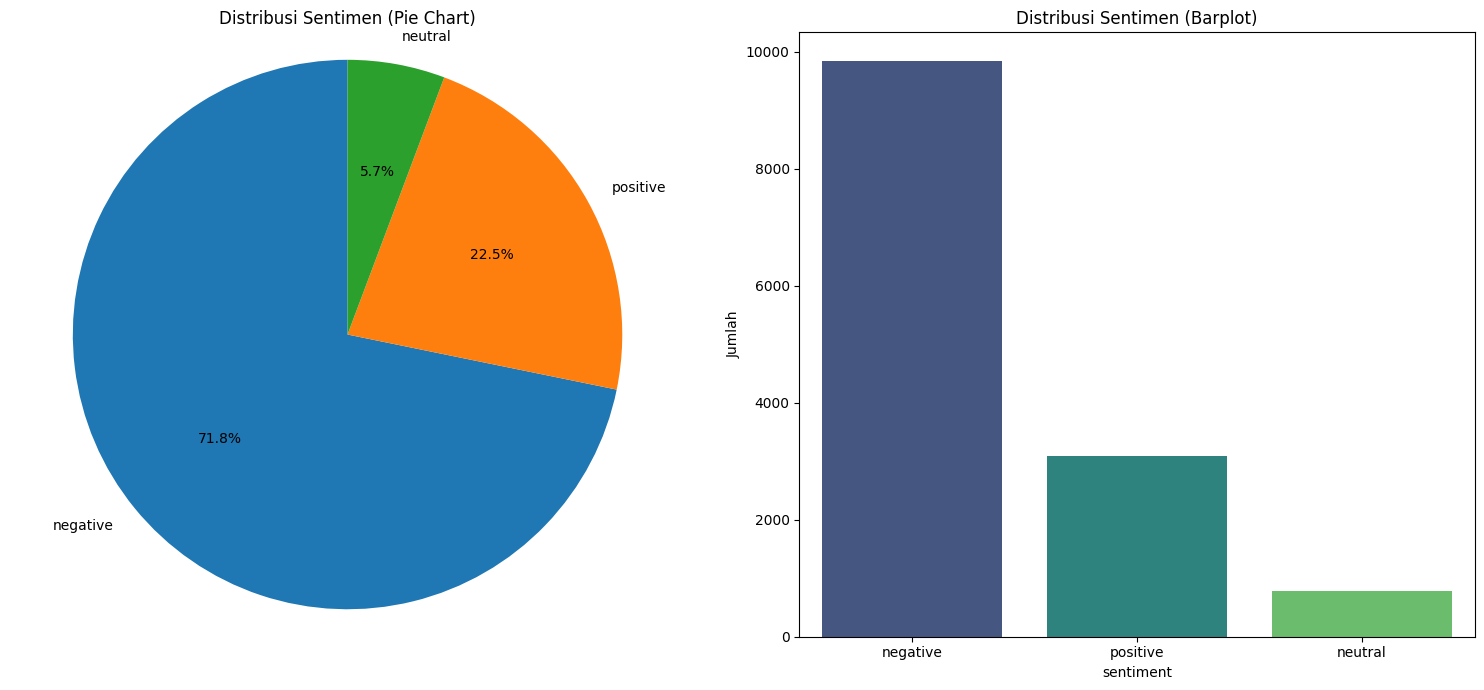

In [22]:

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Pie chart
axes[0].pie(df['sentiment'].value_counts(), labels=df['sentiment'].value_counts().index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Distribusi Sentimen (Pie Chart)')
axes[0].axis('equal')

# Barplot
sns.barplot(x=df['sentiment'].value_counts().index, y=df['sentiment'].value_counts().values, ax=axes[1], palette='viridis')
axes[1].set_title('Distribusi Sentimen (Barplot)')
axes[1].set_ylabel('Jumlah')

# Menampilkan plot
plt.tight_layout()
plt.show()


<ipython-input-23-14d03bdd7f9e>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), ax=axes[1], palette='viridis')


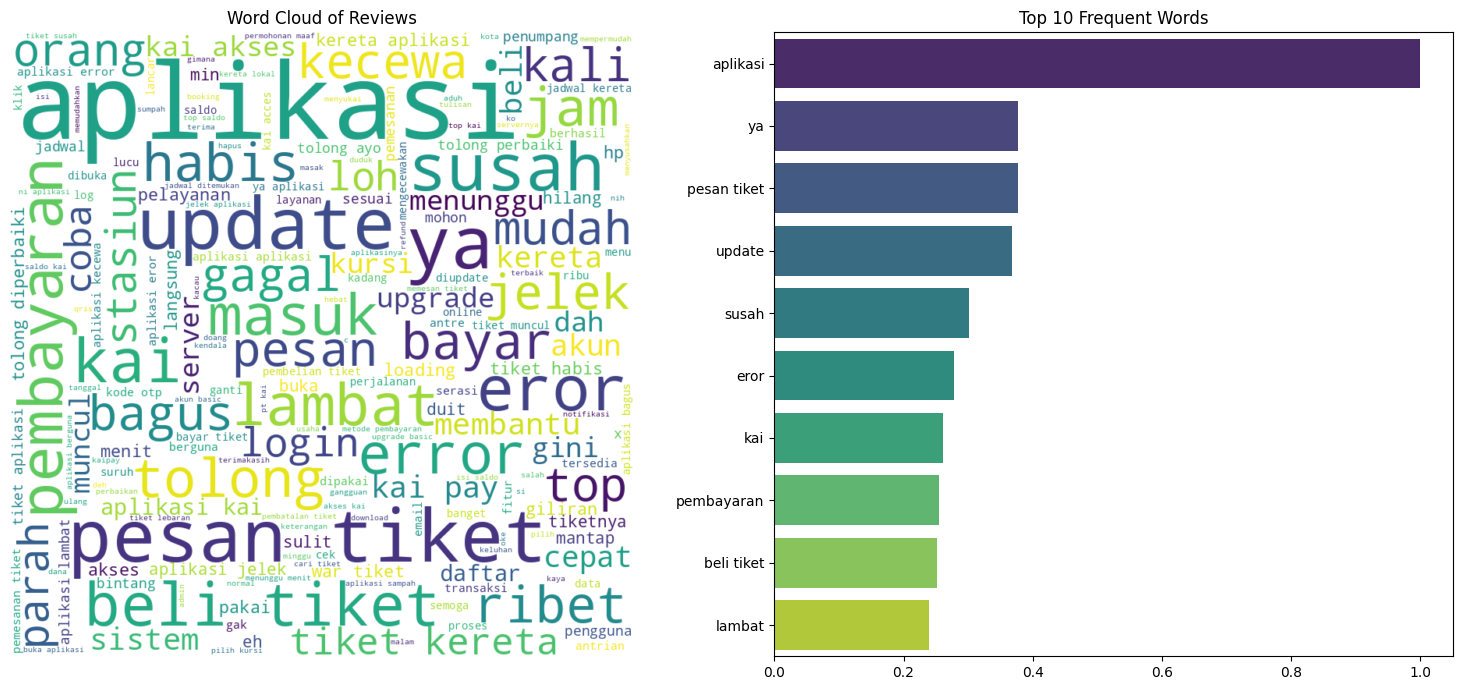

In [23]:
# Menggabungkan semua teks dari kolom 'text_akhir' yang sudah dibersihkan
text_cleaned = ' '.join(df['text_akhir'].dropna().tolist())

# Membuat WordCloud
wordcloud = WordCloud(width=800, height=800, background_color='white').generate(text_cleaned)

# Mendapatkan frekuensi kata dari wordcloud
frequencies = wordcloud.words_

# Menyiapkan data untuk barplot (10 kata paling sering)
words, counts = zip(*list(frequencies.items())[:10])

# Membuat subplots (2 kolom: WordCloud dan Barplot)
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Menampilkan WordCloud
axes[0].imshow(wordcloud, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Word Cloud of Reviews')

# Menampilkan horizontal barplot
sns.barplot(x=list(counts), y=list(words), ax=axes[1], palette='viridis')
axes[1].set_title('Top 10 Frequent Words')

# Menampilkan plot
plt.tight_layout()
plt.show()

# **5. Pembangunan Model**

In [24]:
lebel_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}
df['sentiment_label'] = df['sentiment'].map(lebel_mapping)

In [25]:
X = df['text_akhir']
y = df['sentiment_label']

# Ekstraksi fitur dengan TF-IDF
tfidf = TfidfVectorizer(max_features=500, min_df=20, max_df=0.8)
X_tfidf = tfidf.fit_transform(X)

# Bagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)
print("Jumlah data latih:", X_train.shape[0])
print("Jumlah data uji:", X_test.shape[0])

Jumlah data latih: 9597
Jumlah data uji: 4113


In [26]:
X_train = X_train.toarray()
X_test = X_test.toarray()

In [ ]:
# Membuat Model RNN
rnn_model = Sequential()

# Layer embedding
rnn_model.add(Embedding(input_dim=10000, output_dim=100, input_length=100))

# Menambahkan lapisan RNN
rnn_model.add(SimpleRNN(units=128, activation='softmax', return_sequences=True))
rnn_model.add(SimpleRNN(units=64, activation='softmax'))

# Layer output
rnn_model.add(Dense(3, activation='softmax'))  # 3 kelas: positive, neutral, negative

# Menyusun model
rnn_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Ringkasan model
rnn_model.build(input_shape=(None, 100))
rnn_model.summary()

# Melatih model RNN
rnn_history = rnn_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=2)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 100, 128)       │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,041,859 (3.97 MB)

 Trainable params: 1,041,859 (3.97 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
150/150 - 121s - 807ms/step - accuracy: 0.7191 - loss: 0.9784 - val_accuracy: 0.7150 - val_loss: 0.8926
Epoch 2/10
150/150 - 121s - 806ms/step - accuracy: 0.7191 - loss: 0.8399 - val_accuracy: 0.7150 - val_loss: 0.8049
Epoch 3/10
150/150 - 120s - 799ms/step - accuracy: 0.7191 - loss: 0.7797 - val_accuracy: 0.7150 - val_loss: 0.7681
Epoch 4/10
150/150 - 110s - 733ms/step - accuracy: 0.7191 - loss: 0.7544 - val_accuracy: 0.7150 - val_loss: 0.7525
Epoch 5/10
150/150 - 121s - 804ms/step - accuracy: 0.7191 - loss: 0.7436 - val_accuracy: 0.7150 - val_loss: 0.7456
Epoch 6/10
150/150 - 145s - 964ms/step - accuracy: 0.7191 - loss: 0.7389 - val_accuracy: 0.7150 - val_loss: 0.7427
Epoch 7/10
150/150 - 152s - 1s/step - accuracy: 0.7191 - loss: 0.7368 - val_accuracy: 0.7150 - val_loss: 0.7416
Epoch 8/10


In [35]:
# Create LSTM model
lstm_model = Sequential([
    Embedding(input_dim=20000, output_dim=100, input_length=100),
    GRU(units=256, activation='tanh'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

# Compile the model
lstm_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
lstm_model.build(input_shape=(None, 8))
lstm_model.summary()

# Train the model
lstm_history = lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=2, callbacks=[EarlyStopping(monitor='accuracy', patience=3, restore_best_weights=True)])


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 8, 100)         │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 256)            │       274,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,275,715 (8.68 MB)

 Trainable params: 2,275,715 (8.68 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
343/343 - 177s - 517ms/step - accuracy: 0.6298 - loss: 0.9228 - val_accuracy: 0.6296 - val_loss: 0.9267
Epoch 2/10


KeyboardInterrupt: 

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Create CNN model
cnn_model = Sequential([
    # Embedding layer
    Embedding(input_dim=20000, output_dim=100, input_length=100),

    # Convolutional layer with 128 filters and kernel size of 3
    Conv1D(filters=128, kernel_size=3, activation='relu'),

    # Max pooling to downsample
    MaxPooling1D(pool_size=2),

    # Flatten the output of the convolutional layers
    Flatten(),

    # Dense layer
    Dense(64, activation='relu'),

    # Dropout to prevent overfitting
    Dropout(0.5),

    # Output layer for 3 classes
    Dense(3, activation='softmax')  # 3 classes: positive, neutral, negative
])

# Compile the model
cnn_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
cnn_model.summary()

# Callback for early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

# Train the CNN model
cnn_history = cnn_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,  # Smaller batch size for faster iterations
    validation_data=(X_test, y_test),
    verbose=2,  # Verbose for seeing the progress
    callbacks=[early_stopping]
)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
374/374 - 31s - 82ms/step - accuracy: 0.9150 - loss: 0.3924 - val_accuracy: 0.9160 - val_loss: 0.3772
Epoch 2/10
374/374 - 43s - 114ms/step - accuracy: 0.9191 - loss: 0.3621 - val_accuracy: 0.9160 - val_loss: 0.3472
Epoch 3/10
374/374 - 39s - 105ms/step - accuracy: 0.9191 - loss: 0.3531 - val_accuracy: 0.9160 - val_loss: 0.3517
Epoch 4/10
374/374 - 22s - 58ms/step - accuracy: 0.9191 - loss: 0.3461 - val_accuracy: 0.9160 - val_loss: 0.3422
